# TRABAJO PRÁCTICO 3
# Alumno: Ezequiel Scordamaglia

## Detección de Logotipo usando Template matching

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

In [79]:
def calcular_cantidad_reducciones(width, final_width, porcentaje_reduccion):
    if final_width >= width:
        raise ValueError("El tamaño final debe ser menor que el tamaño original.")

    cantidad_reducciones = 0
    while width > final_width:
        width *= porcentaje_reduccion
        cantidad_reducciones += 1

    return cantidad_reducciones

def template_matching(imgList, template_path, threshold, detection_type='single'):
    """
    imgList: lista de imagenes
    template_path: path del template
    threshold: umbral de deteccion
    detection_type: 'single' o 'multiple'
    """

    # TEMPLATE
    template = cv.imread(template_path)
    template_gray= cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    w, h = template_gray.shape[::-1]
    # Aplicar deteccion de bordes
    template_gray = cv.Canny(template_gray, 500, int(w*0.8))
    # Invertir la imagen template
    template_gray = cv.bitwise_not(template_gray)


    for image in imgList:
        
        # IMAGEN
        img = cv.imread(image)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        w_img, h_img = img_gray.shape[::-1]
        # Aplicar deteccion de bordes
        img_gray = cv.Canny(img_gray, 500, int(w_img*0.8))
        # Invertimos
        img_gray = cv.bitwise_not(img_gray)

        # COPIA
        template_copy = template_gray.copy()
        

        # Si el template es mas chico que la imagen, los pongo al mismo tamaño
        if (w < w_img):
            template_copy = cv.resize(template_copy, (img_gray.shape[1], int(img_gray.shape[1]*template_copy.shape[0]/template_copy.shape[1])))
            w, h = template_gray.shape[::-1]

        # Calcular cantidad de reducciones del template segun el tamaño de la imagen
        porcentaje_reduccion = 0.97
        cantidad_reducciones = calcular_cantidad_reducciones(w_img, w_img//9, porcentaje_reduccion)

        # print("Cantidad de reducciones: ", cantidad_reducciones)

        cantidad_reducciones_con_detecciones = 0

        for i in range(int(cantidad_reducciones)):
            # print("Reduccion: ", i)
            # print("Tamaño template: ", template_copy.shape)
            # print("Tamaño imagen: ", img_gray.shape)                

            # Si el template es mas chico que la imagen, continuo
            if w < w_img and h < h_img:
                res = cv.matchTemplate(img_gray,template_copy,cv.TM_CCOEFF_NORMED)
                loc = np.where( res >= threshold)

                if (len(loc[0]) > 1):
                    # print("Tamaño template: ", template_copy.shape)
                    # print("Se encontraron ", len(loc[0]), " coincidencias.")
                    if detection_type == 'single':
                        # Max value
                        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                        top_left = max_loc
                        bottom_right = (top_left[0] + w, top_left[1] + h)
                        cv.rectangle(img_rgb,top_left, bottom_right, (0,0,255), 2)
                        cv.putText(img_rgb, str(round(max_val, 2)), (top_left[0], top_left[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)
                        break;
                    else:
                        boxes = []
                        scores = []
                        for pt in zip(*loc[::-1]):
                            boxes.append([pt[0], pt[1], w, h])
                            scores.append(res[pt[1], pt[0]])
                        boxes = np.array(boxes)
                        scores = np.array(scores)
                        indices = cv.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), 0.01, 0.05)

                        # print("Cantidad de indices filtrados: ", len(indices))
                        # print("Indices filtrados: ", indices)

                        for i in range(len(boxes)):
                            if i in indices:
                                label = str(round(scores[i], 2))
                                x, y, w, h = boxes[i]
                                color = (0, 0, 255)
                                cv.rectangle(img_rgb, (x, y), (x + w, y + h), color, 2)
                                cv.putText(img_rgb, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.7, color, 1)

                        cantidad_reducciones_con_detecciones += 1

                        if cantidad_reducciones_con_detecciones > 3:
                            break

            template_copy = cv.resize(template_copy, (0,0), fx=porcentaje_reduccion, fy=porcentaje_reduccion)
            w, h = template_copy.shape[::-1]

        # plt.figure()
        # plt.imshow(template_copy, cmap='gray')
        # plt.show()

        plt.figure()
        plt.imshow(img_rgb)
        plt.show()

    return

### Se procesa cada imagen con el mismo algoritmo para detectar el logotipo de Coca-Cola

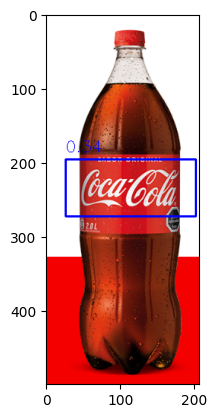

In [80]:
template_matching(['images/coca_logo_1.png'], 'template/pattern.png', 0.34, 'single')

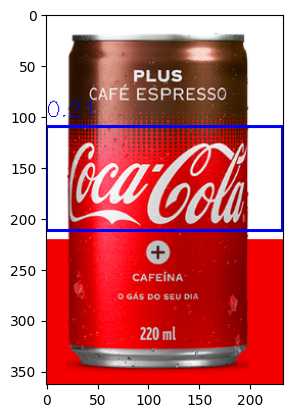

In [63]:
template_matching(['images/coca_logo_2.png'], 'template/pattern.png', 0.20, 'single')

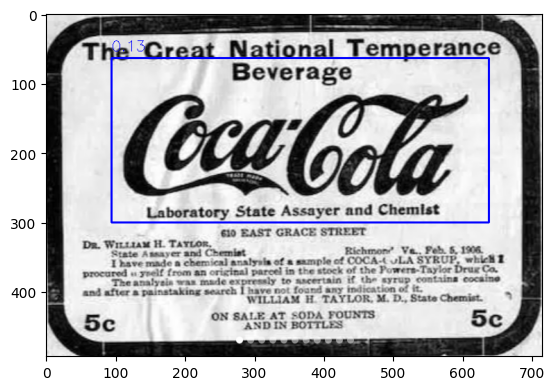

In [64]:
template_matching(['images/coca_retro_1.png'], 'template/pattern.png', 0.11, 'single')

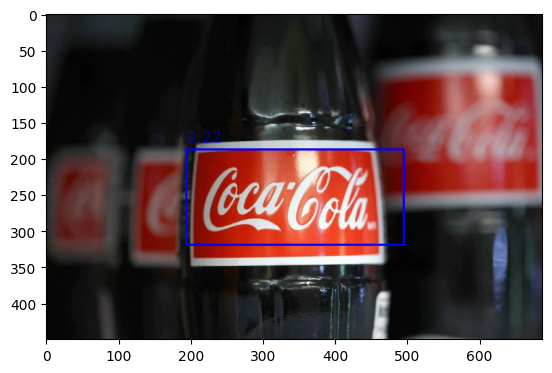

In [65]:
template_matching(['images/logo_1.png'], 'template/pattern.png', 0.21, 'single')

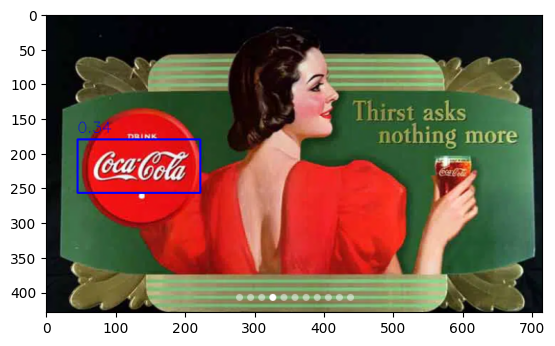

In [66]:
template_matching(['images/coca_retro_2.png'], 'template/pattern.png', 0.33, 'single')

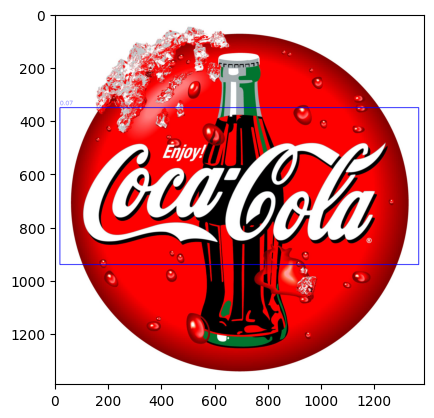

In [68]:
template_matching(['images/COCA-COLA-LOGO.jpg'], 'template/pattern.png', 0.06, 'single')

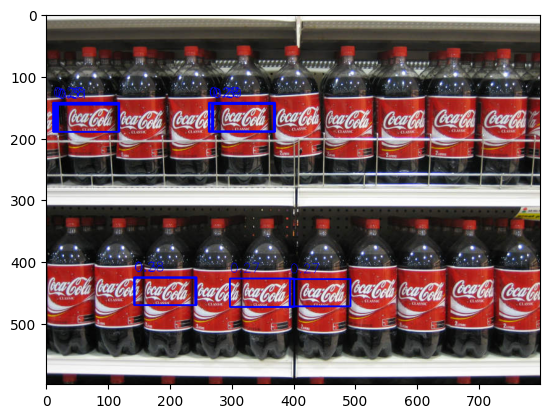

In [72]:
template_matching(['images/coca_multi.png'], 'template/pattern.png', 0.265, 'multi')

### Todos los logotipos fueron detectados correctamente sin falsos positivos

### Se intenta procesar todas las imagenes por el mismo algoritmo con un mismo umbral de deteccion

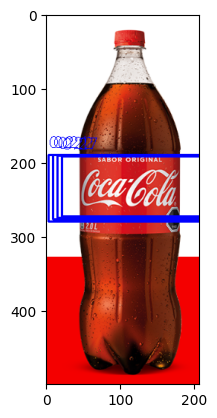

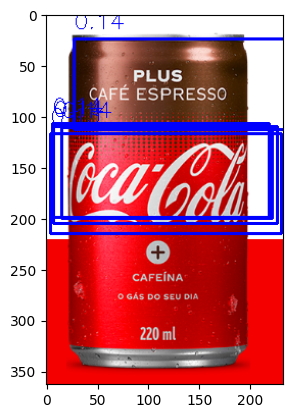

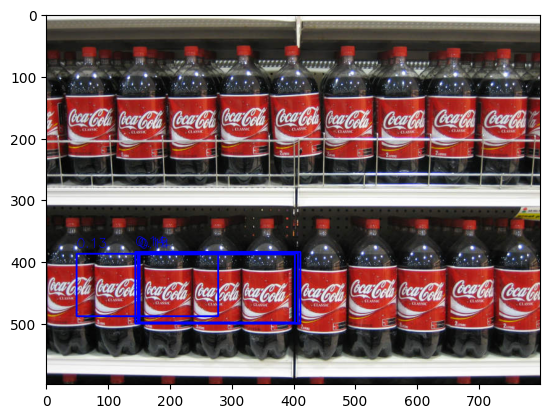

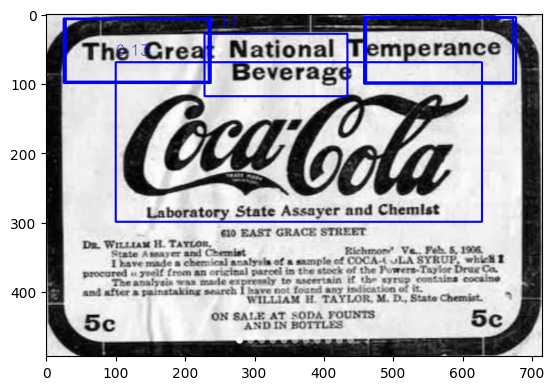

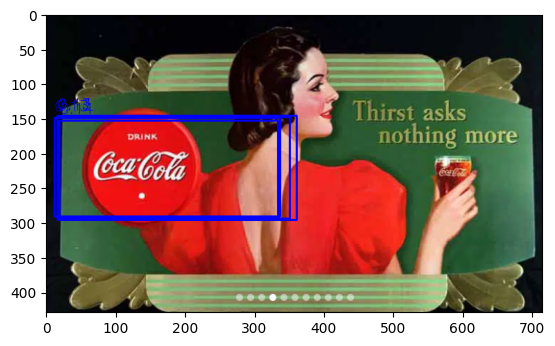

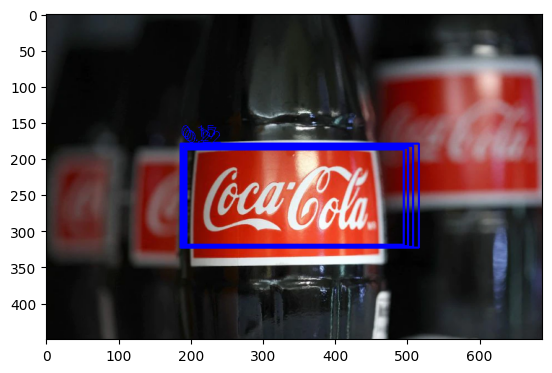

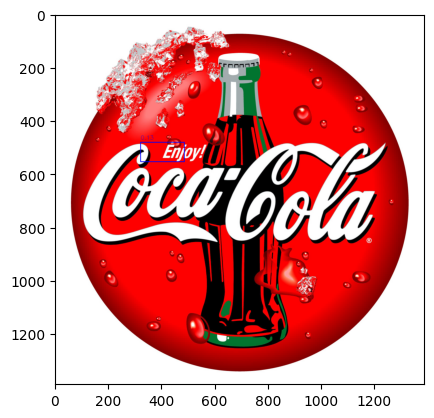

In [84]:
#Lista de imagenes a cargar
images = glob.glob('images/*.png')
images.extend(glob.glob('images/*.jpg'))

# Eliminar de la lista la que se llama coca_multi.png
# images = [x for x in images if x != 'images\\coca_multi.png']

template_matching(images, 'template/pattern.png', 0.13, 'multi')

### En este caso no se pudo detectar los logos correctamente usando un mismo umbral para cualquer imagen  de entrada. Habría que hacer algunos ajustes mas en el algoritmo para que mejore las detecciones en imagenes grnades, asi se puede usar un umbral mas alto para las detecciones.